In this notebook we generate and plot shown in Fig.3 of the main
text.

In [2]:
from qutip import *
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from matplotlib import rc
import matplotlib as mpl
import scipy.optimize as opt
from scipy.interpolate import griddata
rc('text', usetex=True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["legend.borderpad"] = 0.15
mpl.rcParams["font.size"] = 8

In [3]:
N=6 # choose the system size for both Source and Decoder
# Collective spin operators 
S_x = jmat(N/2, 'x')
S_y = jmat(N/2, 'y')
S_z = jmat(N/2, 'z')
S_p = jmat(N/2, '+')
S_m = jmat(N/2, '-')
idenJ = qeye(S_z.shape[0])
# operators of the Source system S_1
S_x1 = tensor(S_x, idenJ)
S_x2 = tensor(idenJ, S_x)
S_m1 = tensor(S_m, idenJ)
# operators of the Decoder system S_2
S_m2 = tensor(idenJ, S_m)
S_p1 = tensor(S_p, idenJ)
S_p2 = tensor(idenJ, S_p)
# new identity
idenJ = tensor(idenJ, idenJ)

#physical parameters for computation
ratios  = np.linspace(0,4,100) # ratios of omega/omega_c to be scanned
dphis   = np.linspace(0,2*np.pi,100) # values of \varphi-\varphi' to be scanned
omega_c = N/2 # critical frequency for given system size N
def compute_row(ratio, dphi, omega_c, S_x1, S_x2, S_p2, S_m1, S_m2, S_p1):
    """A function to compute a single row of the output data. Helper function 
    for parallelization. For each pair of (ratio, dphi), compute the stationary
    properties of the cascaded system and return them as a list. All stationary 
    properties can be obtained form the stationary density matrix rho_ss."""
    omega   = ratio*omega_c
    Ham     = omega*(S_x1+S_x2) - 0.5j*(np.exp(-1j*dphi)*S_p2*S_m1
                                         - np.exp(1j*dphi)*S_m2*S_p1)
    Jump    = np.exp(-1j*dphi)*S_m1+S_m2
    Liou    = liouvillian(Ham, [Jump])
    rho_ss  = steadystate(Liou, method='direct') # stationary state
    int_ss  = abs((Jump.dag()*Jump*rho_ss).tr()) # stationary intensity
    pur_ss  = abs((rho_ss*rho_ss).tr())          # stationary purity
    ent_ss  = entropy_vn(rho_ss)                 # stationary von Neumann entropy
    ent_S_ss= entropy_vn(rho_ss.ptrace(0))       # entropy of the Source
    ent_D_ss= entropy_vn(rho_ss.ptrace(1))       # entropy of the Decoder
    return [ratio, dphi, int_ss, pur_ss, ent_ss, ent_S_ss, ent_D_ss]
# Parallel computation of all rows
results = Parallel(n_jobs=-1)(
    delayed(compute_row)(beta, dphi, omega_c, S_x1, S_x2, S_p2, S_m1, S_m2, S_p1)
    for beta in ratios for dphi in dphis
)

int_pur = np.array(results)
df  = pd.DataFrame(int_pur)
df.to_csv('stationary_props_N'+str(N)+'.csv', 
          index_label=['index', 'ratio', 'dphi', 'int_ss', 'pur_ss', 'ent_ss',
                       'ent_S_ss', 'ent_D_ss'],
          header=True)  

/tmp/ipykernel_76757/1955917120.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


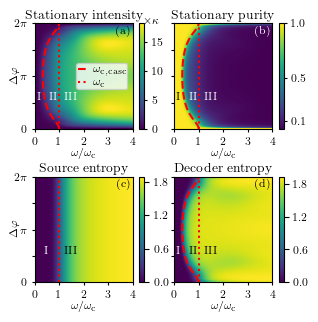

In [4]:
fig , axs = plt.subplots(2,4,
                        figsize=(0.95*3.54331,0.95*3.54331),
                        width_ratios=[1,0.05,1,0.05], # ensure colorbars
                                                      # have correct size
                        gridspec_kw={'wspace':0.35, 'hspace':0.45})

# Load data from same directory into a dataframe
df  = pd.read_csv('stationary_props_N6.csv')
df  = pd.DataFrame(df)

# extract data for plotting
x   = df['ratio']
y   = df['dphi']
z1  = df['int_ss']
z2  = df['pur_ss']
z3  = df['ent_D_ss']
z4  = df['ent_S_ss']
# define grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolate grid data
grid_z1  = griddata((x, y), z1, (grid_x, grid_y), method='cubic')
grid_z2  = griddata((x, y), z2, (grid_x, grid_y), method='cubic')
grid_z3  = griddata((x, y), z3, (grid_x, grid_y), method='cubic')
grid_z4  = griddata((x, y), z4, (grid_x, grid_y), method='cubic')

#------------------------------------------------------------------------------#
# Plot the stationary intensity of the cascaded system
picture = axs[0][0].imshow(grid_z1.T, extent = (min(x), max(x), min(y), max(y)),
           origin = 'lower', cmap = 'viridis', aspect = 'auto')
axs[0][0].set_xlabel(r'$\omega/\omega_\mathrm{c}$')
axs[0][0].set_ylabel(r'$\Delta \varphi$')
axs[0][0].set_yticks([0,np.pi*0.5,np.pi,1.5*np.pi,2*np.pi])
axs[0][0].set_yticklabels(['0',r'', r'$\pi$', r'',r'$2\pi$'])
axs[0][0].set_xticks([0,1,2,3,4])
axs[0][0].plot(1/np.sqrt(5-4*np.cos(np.linspace(0,2*np.pi,50))),
         np.linspace(0,2*np.pi,50), 'r--', label=r'$\omega_\mathrm{c,casc}$')
axs[0][0].plot([1,1],[0,2*np.pi], 'r:', label=r'$\omega_\mathrm{c}$')
fig.colorbar(picture, cax=axs[0][1], ticks=[0,5,10,15])
axs[0][1].tick_params(axis='both', length=2) 
axs[0][0].tick_params(axis='both', length=2) 
axs[0][1].set_position([
    axs[0][1].get_position().x0 - 0.035,  # move left
    axs[0][1].get_position().y0,
    axs[0][1].get_position().width,
    axs[0][1].get_position().height
])
axs[0][0].set_title('Stationary intensity', pad=3)
axs[0][0].yaxis.set_label_coords(-0.15, 0.5)  # Adjust y-label position
axs[0][0].xaxis.set_label_coords(0.5, -0.175)  # Adjust x-label position for all
axs[0][0].text(0.98, 0.98, '(a)', transform=axs[0][0].transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='right')
axs[0][0].text(0.02,0.3,'I', color='white', transform=axs[0][0].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[0][0].text(0.15,0.3,'II', color='white', transform=axs[0][0].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[0][0].text(0.3,0.3,'III', color='white', transform=axs[0][0].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[0][0].legend(loc='best', handlelength=1, labelspacing=0.2, handletextpad=0.3, borderpad=0.15)
axs[0][1].text(1.035,0.985, r'$\times \kappa$', transform=axs[0][1].transAxes,
               fontsize=8, verticalalignment='bottom', horizontalalignment='left')

#------------------------------------------------------------------------------#
# Plot the stationary purity of the cascaded system
#------------------------------------------------------------------------------#
picture1 = axs[0][2].imshow(grid_z2.T, extent = (min(x), max(x), min(y), max(y)),
           origin = 'lower', cmap = 'viridis', aspect = 'auto')
axs[0][2].set_xlabel(r'$\omega/\omega_\mathrm{c}$')
axs[0][2].set_yticks([0,np.pi*0.5,np.pi,1.5*np.pi,2*np.pi])
axs[0][2].set_yticklabels(['','', '', '',''])
axs[0][2].set_xticks([0,1,2,3,4])
axs[0][2].plot(1/np.sqrt(5-4*np.cos(np.linspace(0,2*np.pi,50))),
         np.linspace(0,2*np.pi,50), 'r--')
axs[0][2].plot([1,1],[0,2*np.pi], 'r:')
axs[0][2].tick_params(axis='both', length=2) 
fig.colorbar(picture1, cax=axs[0][3], ticks=[0.1,0.5,1])
axs[0][3].tick_params(axis='both', length=2) 
axs[0][3].set_position([
    axs[0][3].get_position().x0 - 0.035,  # move left
    axs[0][3].get_position().y0,
    axs[0][3].get_position().width,
    axs[0][3].get_position().height
])
axs[0][2].set_title('Stationary purity', pad=3)
axs[0][2].xaxis.set_label_coords(0.5, -0.175)  # Adjust x-label position for all
axs[0][2].text(0.98, 0.98, '(b)', transform=axs[0][2].transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='right', color='white')
axs[0][2].text(0.02,0.3,'I', color='black', transform=axs[0][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[0][2].text(0.15,0.3,'II', color='white', transform=axs[0][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[0][2].text(0.3,0.3,'III', color='white', transform=axs[0][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')

#------------------------------------------------------------------------------#
# Plot the stationary entropy of the Source system
#------------------------------------------------------------------------------#
picture2 = axs[1][0].imshow(grid_z4.T, extent = (min(x), max(x), min(y), max(y)),
           origin = 'lower', cmap = 'viridis', aspect = 'auto')
axs[1][0].set_xlabel(r'$\omega/\omega_\mathrm{c}$')
axs[1][0].set_yticks([0,np.pi*0.5,np.pi,1.5*np.pi,2*np.pi])
axs[1][0].set_yticklabels(['','','','',''])
axs[1][0].set_xticks([0,1,2,3,4])
axs[1][0].vlines(1,0,2*np.pi,colors='red', linestyles='dotted',linewidth=1.5)
axs[1][0].tick_params(axis='both', length=2) 
axs[1][0].set_ylabel(r'$\Delta \varphi$')
axs[1][0].set_yticklabels(['0',r'', r'$\pi$', r'',r'$2\pi$'])
fig.colorbar(picture2, ticks=[0,0.6,1.2,1.8], 
             cax=axs[1][1])
axs[1][1].set_position([
    axs[1][1].get_position().x0 - 0.035,  # move left
    axs[1][1].get_position().y0,
    axs[1][1].get_position().width,
    axs[1][1].get_position().height
])
axs[1][0].set_title('Source entropy', pad=3)
axs[1][0].yaxis.set_label_coords(-0.15, 0.5)  # Adjust y-label position
axs[1][0].xaxis.set_label_coords(0.5, -0.175)  # Adjust x-label position for all
axs[1][0].text(0.98, 0.98, '(c)', transform=axs[1][0].transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='right')
axs[1][0].text(0.1,0.3,'I', color='white', transform=axs[1][0].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[1][0].text(0.3,0.3,'III', color='black', transform=axs[1][0].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')

#------------------------------------------------------------------------------#
# Plot the stationary entropy of the Decoder system
#------------------------------------------------------------------------------#
picture3 = axs[1][2].imshow(grid_z3.T, extent = (min(x), max(x), min(y), max(y)),
           origin = 'lower', cmap = 'viridis', aspect = 'auto')
axs[1][2].set_xlabel(r'$\omega/\omega_\mathrm{c}$')
axs[1][2].set_yticks([0,np.pi*0.5,np.pi,1.5*np.pi,2*np.pi])
axs[1][2].set_yticklabels(['','','','',''])
axs[1][2].set_xticks([0,1,2,3,4])
axs[1][2].plot(1/np.sqrt(5-4*np.cos(np.linspace(0,2*np.pi,50))),
         np.linspace(0,2*np.pi,50), 'r--')
axs[1][2].plot([1,1],[0,2*np.pi], 'r:')
fig.colorbar(picture3, ticks=[0,0.6,1.2,1.8],
             cax=axs[1][3])
axs[1][3].set_position([
    axs[1][3].get_position().x0 - 0.035,  # move left
    axs[1][3].get_position().y0,
    axs[1][3].get_position().width,
    axs[1][3].get_position().height
])
axs[1][2].tick_params(axis='both', length=2) 
axs[1][2].tick_params(axis='both', length=2) 
axs[1][2].set_title('Decoder entropy', pad=3)
axs[1][2].xaxis.set_label_coords(0.5, -0.175)  # Adjust x-label position for all
axs[1][2].text(0.98, 0.98, '(d)', transform=axs[1][2].transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='right')
axs[1][2].text(0.02,0.3,'I', color='white', transform=axs[1][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[1][2].text(0.15,0.3,'II', color='black', transform=axs[1][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
axs[1][2].text(0.3,0.3,'III', color='black', transform=axs[1][2].transAxes,
               fontsize=8, verticalalignment='center', horizontalalignment='left')
#------------------------------------------------------------------------------#
# Save figure
#------------------------------------------------------------------------------#
fig.tight_layout()
fig.savefig('int_pur_stationary.pdf', dpi=1000)